In [1]:
!pip install google-cloud-bigquery

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Set your Google Cloud Project ID
project_id = "project_id"

# Initialize a BigQuery client
client = bigquery.Client(project=project_id)

In [4]:
query = """
SELECT date, retail_and_recreation_percent_change_from_baseline AS retail_and_recreation, grocery_and_pharmacy_percent_change_from_baseline AS grocery_and_pharmacy,
parks_percent_change_from_baseline AS parks, transit_stations_percent_change_from_baseline AS transit_stations,
workplaces_percent_change_from_baseline AS workplaces, residential_percent_change_from_baseline AS residential
FROM `bigquery-public-data.covid19_google_mobility_eu.mobility_report`
WHERE country_region = 'Germany'
AND sub_region_1 = 'Berlin'
"""

# Execute the query
query_job = client.query(query)

# Convert query result to a pandas DataFrame
results = query_job.to_dataframe()
results = results.dropna()


data= spark.createDataFrame(results)
lines= data.count()
print(lines)

data.show()
data.printSchema()

971
+----------+---------------------+--------------------+-----+----------------+----------+-----------+
|      date|retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|
+----------+---------------------+--------------------+-----+----------------+----------+-----------+
|2021-07-20|                  -19|                  -4|   29|             -31|       -41|          7|
|2022-07-31|                  -21|                   4|   46|              -5|        16|         -5|
|2021-01-16|                  -69|                 -14|  -31|             -56|       -30|         12|
|2021-12-30|                  -16|                  24|  -16|             -44|       -60|         15|
|2022-02-06|                  -42|                 -17|  -36|             -38|        -7|          5|
|2021-06-02|                  -28|                  11|   61|             -25|       -26|          7|
|2021-12-31|                  -46|                 -15|  -14|             -50|

In [5]:
#correlation matrix

from pyspark.ml.feature import VectorAssembler
assembler= VectorAssembler(inputCols=['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential'],
                           outputCol='correlation')
data= assembler.transform(data)
data.show(truncate=False)
from pyspark.ml.stat import Correlation
pearsonCorr= Correlation.corr(data,column="correlation",method="pearson").collect()[0][0]
print(str(pearsonCorr))


+----------+---------------------+--------------------+-----+----------------+----------+-----------+------------------------------------+
|date      |retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|correlation                         |
+----------+---------------------+--------------------+-----+----------------+----------+-----------+------------------------------------+
|2021-07-20|-19                  |-4                  |29   |-31             |-41       |7          |[-19.0,-4.0,29.0,-31.0,-41.0,7.0]   |
|2022-07-31|-21                  |4                   |46   |-5              |16        |-5         |[-21.0,4.0,46.0,-5.0,16.0,-5.0]     |
|2021-01-16|-69                  |-14                 |-31  |-56             |-30       |12         |[-69.0,-14.0,-31.0,-56.0,-30.0,12.0]|
|2021-12-30|-16                  |24                  |-16  |-44             |-60       |15         |[-16.0,24.0,-16.0,-44.0,-60.0,15.0] |
|2022-02-06|-42            

In [6]:
#data preprocessing

data= data.drop("correlation")

assembler2= VectorAssembler(inputCols=['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'workplaces', 'residential'],
                           outputCol='features')
data= assembler2.transform(data)

#use minMax scaler
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaleModel= scaler.fit(data)
prep_data= scaleModel.transform(data)

prep_data.show(truncate=False)

+----------+---------------------+--------------------+-----+----------------+----------+-----------+------------------------------+----------------------------------------------------------------------------------------------------+
|date      |retail_and_recreation|grocery_and_pharmacy|parks|transit_stations|workplaces|residential|features                      |scaledFeatures                                                                                      |
+----------+---------------------+--------------------+-----+----------------+----------+-----------+------------------------------+----------------------------------------------------------------------------------------------------+
|2021-07-20|-19                  |-4                  |29   |-31             |-41       |7          |[-19.0,-4.0,29.0,-41.0,7.0]   |[0.7000000000000001,0.37656903765690375,0.48936170212765956,0.42592592592592593,0.39473684210526316]|
|2022-07-31|-21                  |4                   |46   |-5 

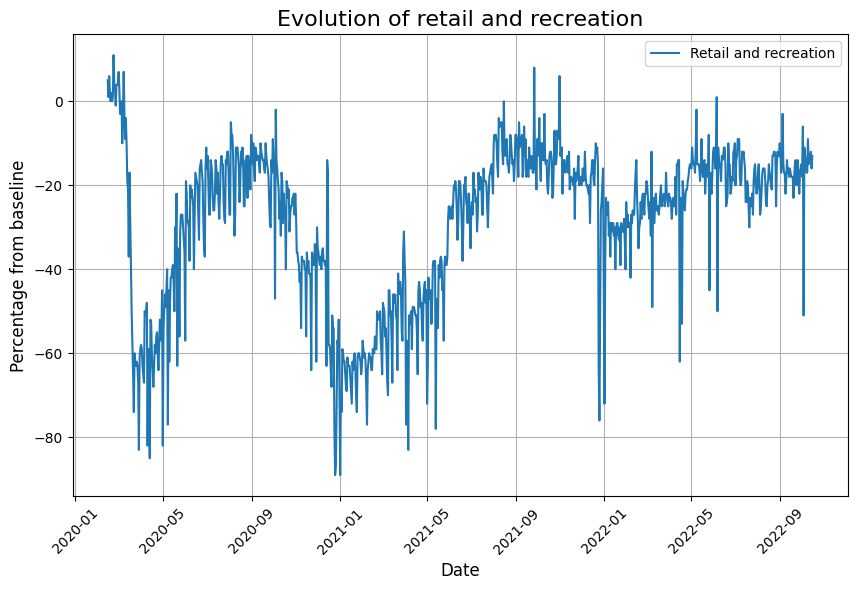

In [7]:
import matplotlib.pyplot as plt

df= prep_data.toPandas()
df= df.sort_values(by='date')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['retail_and_recreation'], label='Retail and recreation')

# Customize the plot
plt.title("Evolution of retail and recreation", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

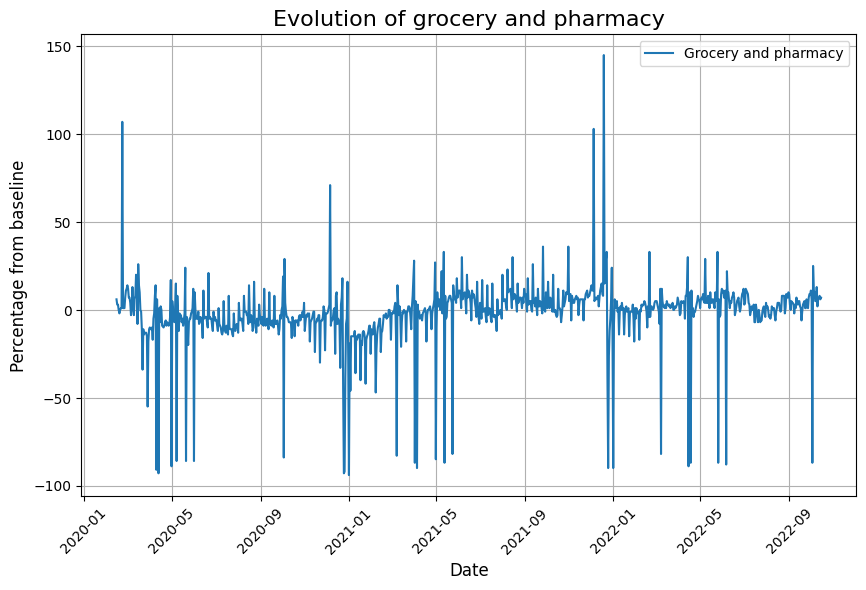

In [8]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['grocery_and_pharmacy'], label='Grocery and pharmacy')

# Customize the plot
plt.title("Evolution of grocery and pharmacy", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

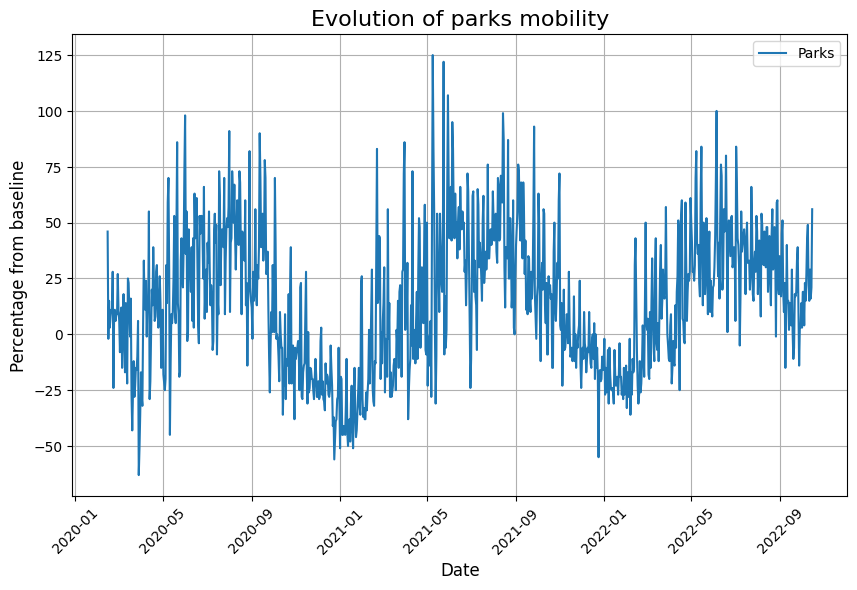

In [9]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['parks'], label='Parks')

# Customize the plot
plt.title("Evolution of parks mobility", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

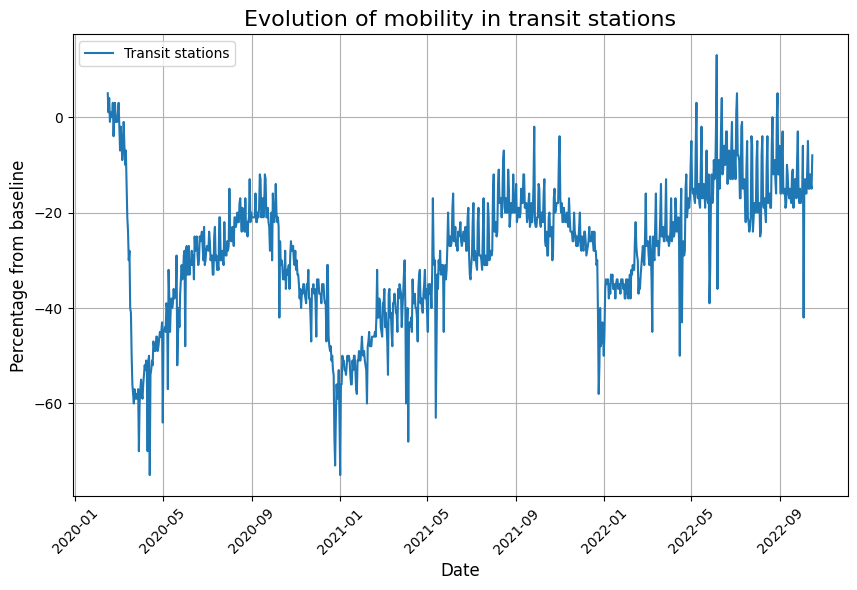

In [10]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['transit_stations'], label='Transit stations')

# Customize the plot
plt.title("Evolution of mobility in transit stations", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

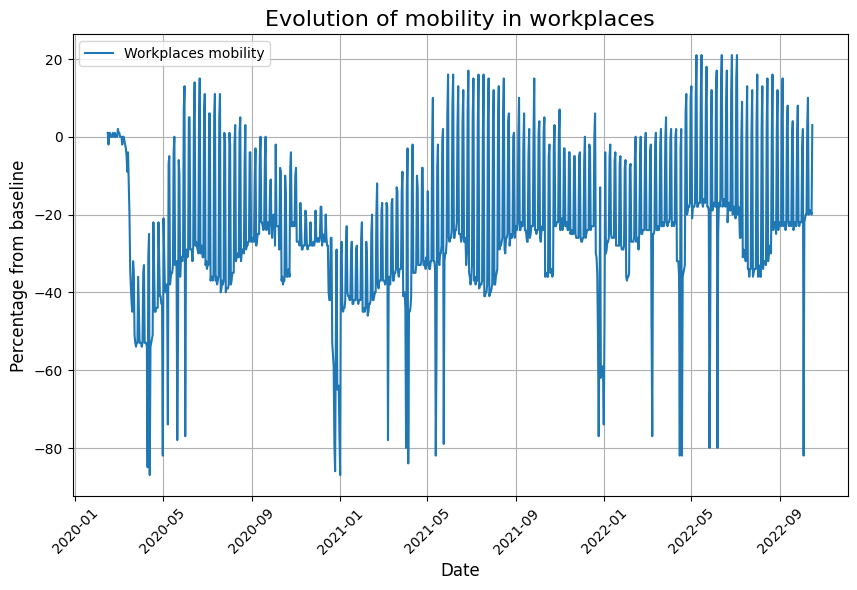

In [11]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['workplaces'], label='Workplaces mobility')

# Customize the plot
plt.title("Evolution of mobility in workplaces", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

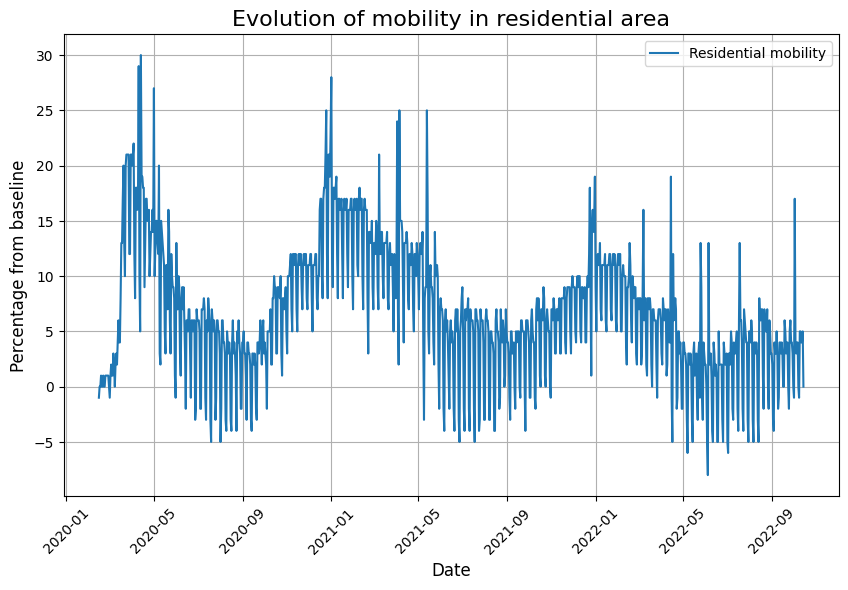

In [12]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['residential'], label='Residential mobility')

# Customize the plot
plt.title("Evolution of mobility in residential area", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [13]:
# Split the DataFrame into training and test sets
(train_data, test_data) = prep_data.randomSplit([0.8, 0.2], seed=1234)

In [14]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Create a LinearRegression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="transit_stations")

evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="transit_stations", metricName="r2")

reg_list=[0, 0.001, 0.01, 0.1] + list(range(1, 10))
elastic_Net_list=[]
for x in range(0, 11, 1):
  elastic_Net_list.append(x * 0.1)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, reg_list) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, elastic_Net_list)\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator= evaluator_r2,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

lr_model= tvs.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("features", "transit_stations", "prediction").show(truncate=False)

r2= evaluator_r2.evaluate(predictions)

evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="transit_stations", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

from pyspark.sql import Row
results_df= spark.createDataFrame([
    Row(Method_name="Linear Regression", R2=r2, RMSE=rmse)
])

results_df.show()

best_model = lr_model.bestModel

print("Best Model Parameters:")
best_reg_param= best_model._java_obj.getRegParam()
best_fitIntercept = best_model._java_obj.getFitIntercept()
best_elasticNetParam = best_model._java_obj.getElasticNetParam()

# Print the best parameters
print(f"Best regParam: {best_reg_param}")
print(f"Best fitIntercept: {best_fitIntercept}")
print(f"Best elasticNetParam: {best_elasticNetParam}")

+------------------------------+----------------+-------------------+
|features                      |transit_stations|prediction         |
+------------------------------+----------------+-------------------+
|[6.0,3.0,15.0,1.0,0.0]        |4               |-4.156477291361803 |
|[0.0,1.0,11.0,0.0,1.0]        |0               |-7.797783712551997 |
|[-50.0,0.0,-27.0,-43.0,17.0]  |-50             |-47.86010949525509 |
|[-63.0,-13.0,-15.0,-54.0,21.0]|-58             |-56.55187064066691 |
|[-63.0,-13.0,-10.0,-53.0,21.0]|-59             |-56.18018921174734 |
|[-67.0,-15.0,6.0,-36.0,12.0]  |-57             |-51.35754705689624 |
|[-59.0,-11.0,-28.0,-54.0,21.0]|-58             |-55.15080968311557 |
|[-56.0,-7.0,28.0,-44.0,15.0]  |-46             |-47.737748945625086|
|[-42.0,-2.0,-13.0,-36.0,14.0] |-40             |-40.823698781605934|
|[-50.0,-9.0,53.0,0.0,3.0]     |-38             |-31.79799919944126 |
|[-30.0,-1.0,21.0,-30.0,8.0]   |-33             |-30.19876610841756 |
|[-30.0,-5.0,47.0,5.

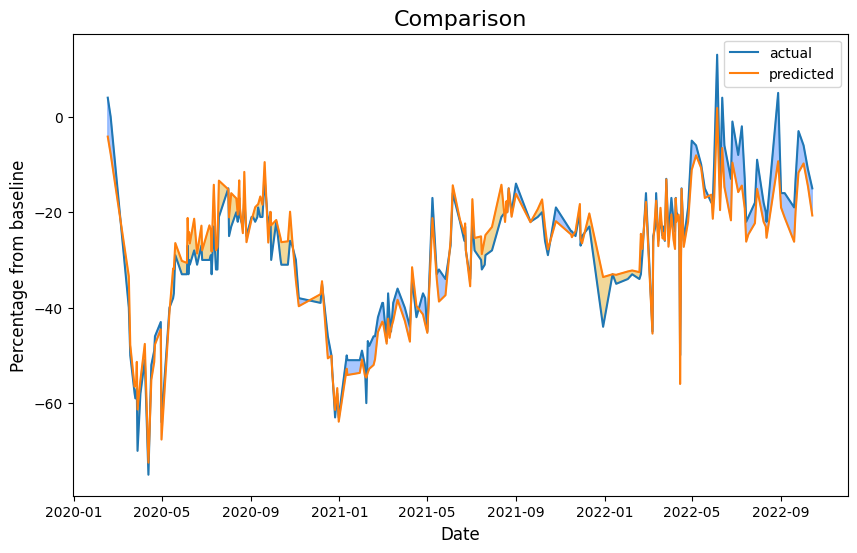

In [15]:
import matplotlib.patches as patches # for the legend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D # for the legend

plt.figure(figsize=(10, 6))
plt.title("Comparison", fontsize=16)
pandas_df= predictions.toPandas()
pandas_df= pandas_df.sort_values(by='date')


plt.plot(pandas_df['date'], pandas_df['transit_stations'], label='actual')
plt.plot(pandas_df['date'], pandas_df['prediction'], label='predicted')
plt.legend()
plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']> pandas_df['prediction']), color="#5490FF", alpha=0.5)

plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']< pandas_df['prediction']), color='#e6b335', alpha=0.5)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.show()

In [16]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="transit_stations", seed=75)

paramGrid2 = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 6, 7, 8, 9]) \
    .addGrid(dt.maxBins, [100, 200, 300])\
    .addGrid(dt.minInstancesPerNode, [1, 3, 5])\
    .build()

tvs2 = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid2,
                           evaluator= evaluator_r2,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

dt_model= tvs2.fit(train_data)

# Make predictions
predictions = dt_model.transform(test_data)

# Show predictions
predictions.select("features", "transit_stations", "prediction").show(truncate=False)

# Make evaluations
r2= evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

# Show results
from pyspark.sql import Row
row_df= spark.createDataFrame([
    Row(Method_name="Decision Tree", R2=r2, RMSE=rmse)
])

results_df= results_df.union(row_df)
results_df.show()

best_model = dt_model.bestModel

print("Best Model Parameters:")
best_maxDepth= best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
best_minInstancesPerNode = best_model.getMinInstancesPerNode()

# Print the best parameters
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best maxBins: {best_maxBins}")
print(f"Best minInstancePerNode: {best_minInstancesPerNode}")

+------------------------------+----------------+-------------------+
|features                      |transit_stations|prediction         |
+------------------------------+----------------+-------------------+
|[6.0,3.0,15.0,1.0,0.0]        |4               |2.0                |
|[0.0,1.0,11.0,0.0,1.0]        |0               |-0.8               |
|[-50.0,0.0,-27.0,-43.0,17.0]  |-50             |-49.5              |
|[-63.0,-13.0,-15.0,-54.0,21.0]|-58             |-58.166666666666664|
|[-63.0,-13.0,-10.0,-53.0,21.0]|-59             |-58.166666666666664|
|[-67.0,-15.0,6.0,-36.0,12.0]  |-57             |-49.25             |
|[-59.0,-11.0,-28.0,-54.0,21.0]|-58             |-56.8              |
|[-56.0,-7.0,28.0,-44.0,15.0]  |-46             |-45.4              |
|[-42.0,-2.0,-13.0,-36.0,14.0] |-40             |-43.111111111111114|
|[-50.0,-9.0,53.0,0.0,3.0]     |-38             |-31.11111111111111 |
|[-30.0,-1.0,21.0,-30.0,8.0]   |-33             |-31.2              |
|[-30.0,-5.0,47.0,5.

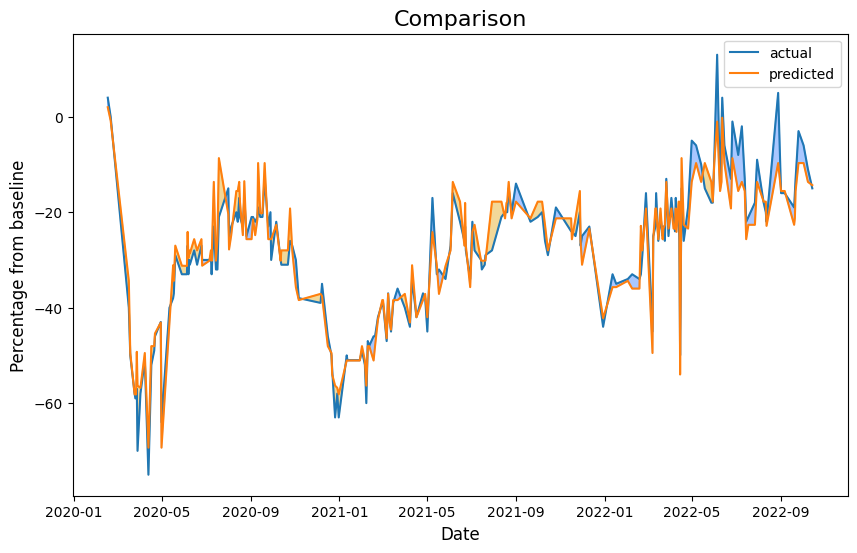

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Comparison", fontsize=16)
pandas_df= predictions.toPandas()
pandas_df= pandas_df.sort_values(by='date')


plt.plot(pandas_df['date'], pandas_df['transit_stations'], label='actual')
plt.plot(pandas_df['date'], pandas_df['prediction'], label='predicted')
plt.legend()
plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']> pandas_df['prediction']), color="#5490FF", alpha=0.5)

plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']< pandas_df['prediction']), color='#e6b335', alpha=0.5)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.show()

In [18]:
from pyspark.ml.regression import GBTRegressor

gbtr = GBTRegressor(featuresCol="scaledFeatures", labelCol="transit_stations", seed=75)

paramGrid3 = ParamGridBuilder()\
    .addGrid(gbtr.featureSubsetStrategy, ['auto','sqrt'])\
    .addGrid(gbtr.maxDepth, [5, 6, 7, 8, 9, 10]) \
    .addGrid(gbtr.maxBins, [100, 200, 300])\
    .addGrid(gbtr.minInstancesPerNode, [1, 3, 5])\
    .build()

tvs3 = TrainValidationSplit(estimator=gbtr,
                           estimatorParamMaps=paramGrid3,
                           evaluator= evaluator_r2,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

gbtr_model= tvs3.fit(train_data)

# Make predictions
predictions = gbtr_model.transform(test_data)

# Show predictions
predictions.select("features", "transit_stations", "prediction").show(truncate=False)

# Make evaluations
r2= evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

# Show results
from pyspark.sql import Row
row_df= spark.createDataFrame([
    Row(Method_name="GBTRegressor", R2=r2, RMSE=rmse)
])

results_df= results_df.union(row_df)
results_df.show()

best_model = gbtr_model.bestModel

print("Best Model Parameters:")
best_featureSubsetStrategy = best_model.getFeatureSubsetStrategy()
best_maxDepth= best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
best_minInstancesPerNode = best_model.getMinInstancesPerNode()

# Print the best parameters
print(f"Best featureSubsetStrategy: {best_featureSubsetStrategy}")
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best maxBins: {best_maxBins}")
print(f"Best minInstancePerNode: {best_minInstancesPerNode}")

+------------------------------+----------------+-------------------+
|features                      |transit_stations|prediction         |
+------------------------------+----------------+-------------------+
|[6.0,3.0,15.0,1.0,0.0]        |4               |3.339219861890469  |
|[0.0,1.0,11.0,0.0,1.0]        |0               |-1.6095705502299382|
|[-50.0,0.0,-27.0,-43.0,17.0]  |-50             |-49.16203112336552 |
|[-63.0,-13.0,-15.0,-54.0,21.0]|-58             |-58.265992430454595|
|[-63.0,-13.0,-10.0,-53.0,21.0]|-59             |-57.967941341738054|
|[-67.0,-15.0,6.0,-36.0,12.0]  |-57             |-52.24645505373125 |
|[-59.0,-11.0,-28.0,-54.0,21.0]|-58             |-57.07406487276735 |
|[-56.0,-7.0,28.0,-44.0,15.0]  |-46             |-45.928593343404955|
|[-42.0,-2.0,-13.0,-36.0,14.0] |-40             |-42.627922808041326|
|[-50.0,-9.0,53.0,0.0,3.0]     |-38             |-29.57437654413041 |
|[-30.0,-1.0,21.0,-30.0,8.0]   |-33             |-31.595313402179137|
|[-30.0,-5.0,47.0,5.

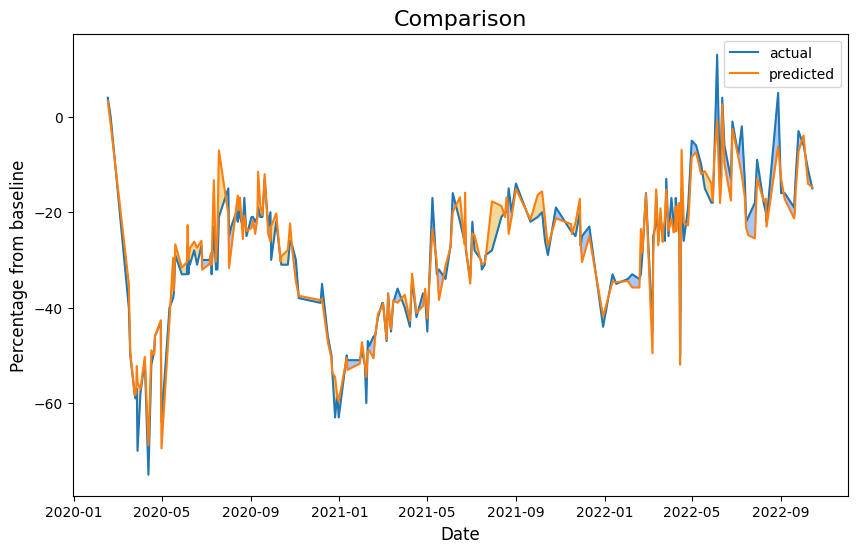

In [19]:
plt.figure(figsize=(10, 6))
plt.title("Comparison", fontsize=16)
pandas_df= predictions.toPandas()
pandas_df= pandas_df.sort_values(by='date')


plt.plot(pandas_df['date'], pandas_df['transit_stations'], label='actual')
plt.plot(pandas_df['date'], pandas_df['prediction'], label='predicted')
plt.legend()
plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']> pandas_df['prediction']), color="#5490FF", alpha=0.5)

plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']< pandas_df['prediction']), color='#e6b335', alpha=0.5)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.show()

In [20]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="transit_stations", seed=75)

paramGrid4 = ParamGridBuilder()\
    .addGrid(rf.featureSubsetStrategy, ['auto','sqrt'])\
    .addGrid(rf.numTrees, [21, 31, 41])\
    .addGrid(rf.maxDepth, [8, 9, 10, 15, 20]) \
    .addGrid(rf.maxBins, [32, 100, 200, 300])\
    .addGrid(rf.minInstancesPerNode, [1, 3, 5])\
    .build()

tvs4 = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid4,
                           evaluator= evaluator_r2,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

rf_model= tvs4.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Show predictions
predictions.select("features", "transit_stations", "prediction").show(truncate=False)

# Make evaluations
r2= evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

# Show results
from pyspark.sql import Row
row_df= spark.createDataFrame([
    Row(Method_name="Random Forest Regressor", R2=r2, RMSE=rmse)
])

results_df= results_df.union(row_df)
results_df.show(truncate=False)

best_model = rf_model.bestModel

print("Best Model Parameters:")
best_featureSubsetStrategy = best_model.getFeatureSubsetStrategy()
best_maxDepth= best_model.getMaxDepth()
best_maxBins = best_model.getMaxBins()
best_minInstancesPerNode = best_model.getMinInstancesPerNode()

# Print the best parameters
print(f"Best featureSubsetStrategy: {best_featureSubsetStrategy}")
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best maxBins: {best_maxBins}")
print(f"Best minInstancePerNode: {best_minInstancesPerNode}")

+------------------------------+----------------+-------------------+
|features                      |transit_stations|prediction         |
+------------------------------+----------------+-------------------+
|[6.0,3.0,15.0,1.0,0.0]        |4               |0.7181259600614438 |
|[0.0,1.0,11.0,0.0,1.0]        |0               |-1.5048387096774194|
|[-50.0,0.0,-27.0,-43.0,17.0]  |-50             |-46.916666666666664|
|[-63.0,-13.0,-15.0,-54.0,21.0]|-58             |-56.89731182795699 |
|[-63.0,-13.0,-10.0,-53.0,21.0]|-59             |-56.85430107526881 |
|[-67.0,-15.0,6.0,-36.0,12.0]  |-57             |-52.45591397849463 |
|[-59.0,-11.0,-28.0,-54.0,21.0]|-58             |-57.23333333333334 |
|[-56.0,-7.0,28.0,-44.0,15.0]  |-46             |-45.460215053763434|
|[-42.0,-2.0,-13.0,-36.0,14.0] |-40             |-40.55798771121352 |
|[-50.0,-9.0,53.0,0.0,3.0]     |-38             |-32.957258064516125|
|[-30.0,-1.0,21.0,-30.0,8.0]   |-33             |-30.031029185867894|
|[-30.0,-5.0,47.0,5.

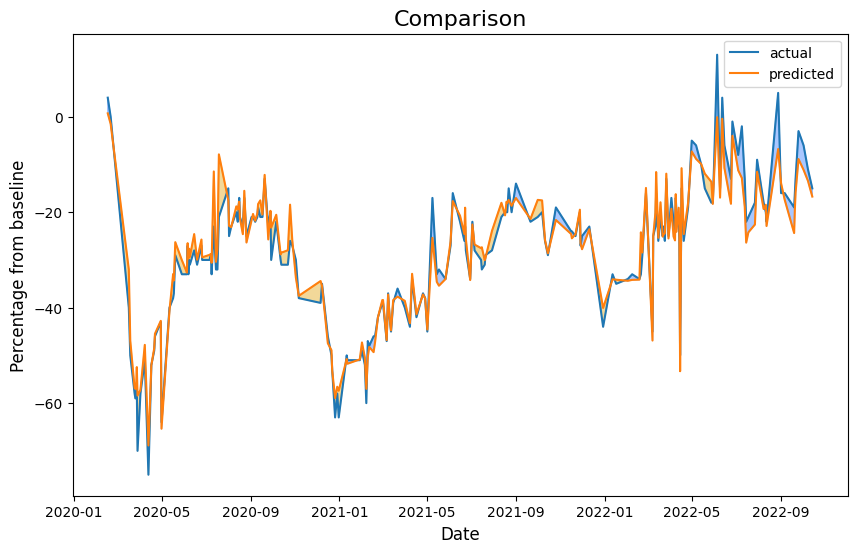

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Comparison", fontsize=16)
pandas_df= predictions.toPandas()
pandas_df= pandas_df.sort_values(by='date')


plt.plot(pandas_df['date'], pandas_df['transit_stations'], label='actual')
plt.plot(pandas_df['date'], pandas_df['prediction'], label='predicted')
plt.legend()
plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']> pandas_df['prediction']), color="#5490FF", alpha=0.5)

plt.fill_between(pandas_df['date'], pandas_df['transit_stations'], pandas_df['prediction'],
                 interpolate=True,
                 where=(pandas_df['transit_stations']< pandas_df['prediction']), color='#e6b335', alpha=0.5)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage from baseline", fontsize=12)
plt.show()